In [2]:
import keras
from keras.models import load_model
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l1
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

Option = namedtuple("MyStruct", "inputModel inputFile tree config jsonModel ")
options = Option(
    inputModel = 'KERAS_conv2d_model_weights.h5',
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_conv2d.yml',
    jsonModel = 'KERAS_conv2d_model.json',
    #outputDir = 'output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
#print(options.inputFile)
yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig


Using TensorFlow backend.


Loading configuration from train_config_conv2d.yml


{'Inputs': ['j1_etarot', 'j1_phirot', 'j1_ptrel', 'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'conv2d_model',
 'KerasModelRetrain': 'conv2d_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'NormalizeInputs': 0,
 'InputType': 'Conv2D',
 'BinsX': 40,
 'MinX': -0.8,
 'MaxX': 0.8,
 'BinsY': 40,
 'MinY': -1.0,
 'MaxY': 1.0,
 'MaxParticles': 100}

In [3]:
f = h5py.File(options.inputFile, 'r')
treeArray = f[options.tree][()]

features = yamlConfig['Inputs']
labels = yamlConfig['Labels']

features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))

features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_labels_df

,j_w,j1_phirot,j_q,j_t,j1_etarot,j_g,j_index,j_z,j1_ptrel
0,0,-0.201170,0,0,-0.068588,0,300003264.0,1,0.001060
1,0,-0.348590,0,1,-0.113826,0,400010240.0,0,0.000626
2,1,0.001577,0,0,0.003166,0,200017616.0,0,0.046280
3,0,-0.005436,0,0,-0.015675,1,12607.0,0,0.132881
4,0,-0.006246,0,1,-0.350233,0,400011040.0,0,0.001762
...,...,...,...,...,...,...,...,...,...
5119904,0,-0.104943,0,0,0.061939,1,6717.0,0,0.003359
5119905,1,-0.271796,0,0,0.003421,0,200000848.0,0,0.003650
5119906,0,-0.242324,0,0,-0.002743,0,300014656.0,1,0.022742
5119907,0,-0.163521,0,0,-0.199286,1,9068.0,0,0.002943


In [4]:
MaxParticles = 100
BinsX = 40
MinX = -0.8
MaxX =  0.8
BinsY = 40
MinY = -1.0
MaxY = 1.0

# Convert to nparray
labels_df = labels_df.drop_duplicates()
features_val = features_df.drop(['j_index'],axis=1).values
labels_val = labels_df.drop(['j_index'],axis=1).values

# get features
features_2dval = np.zeros((len(labels_df), BinsX, BinsY, 1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index'] == labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    xbins = np.linspace(MinX, MaxX, BinsX + 1)
    ybins = np.linspace(MinY, MaxY, BinsY + 1)

    x = features_df_i[features[0]]
    y = features_df_i[features[1]]
    w = features_df_i[features[2]]

    hist, xedges, yedges = np.histogram2d(x, y, weights=w, bins=(xbins, ybins))

    for ix in range(0, BinsX):
        for iy in range(0, BinsY):
            features_2dval[i, ix, iy, 0] = hist[ix, iy]
features_val = features_2dval

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2,
                                                                random_state=42)

# CNN2D model

In [6]:
l1Reg = 0.0001

model = models.Sequential()
model.add(layers.Conv2D(filters=8, kernel_size=(11,11), strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu_1',
               activation = 'relu', kernel_regularizer=l1(l1Reg),input_shape=(40,40, 1)))
model.add(layers.Conv2D(filters=4, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu_2',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Conv2D(filters=2, kernel_size=(3,3), strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv2_relu_3',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(l1Reg)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2_relu_1 (Conv2D)        (None, 40, 40, 8)         976       
_________________________________________________________________
conv2_relu_2 (Conv2D)        (None, 20, 20, 4)         292       
_________________________________________________________________
conv2_relu_3 (Conv2D)        (None, 10, 10, 2)         74        
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165       
Total params: 7,939
Trainable params: 7,939
Non-trainable params: 0
______________________________________________________

In [7]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 15, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/15
15/15 [==============================] - 8s 538ms/step - loss: 1.5809 - accuracy: 0.7610 - val_loss: 1.4650 - val_accuracy: 0.8539
Epoch 2/15
15/15 [==============================] - 7s 498ms/step - loss: 1.2030 - accuracy: 0.8616 - val_loss: 0.7621 - val_accuracy: 0.8684
Epoch 3/15
15/15 [==============================] - 8s 500ms/step - loss: 0.5280 - accuracy: 0.8586 - val_loss: 0.3329 - val_accuracy: 0.8469
Epoch 4/15
15/15 [==============================] - 8s 509ms/step - loss: 0.2498 - accuracy: 0.9171 - val_loss: 0.1720 - val_accuracy: 0.9629
Epoch 5/15
15/15 [==============================] - 8s 538ms/step - loss: 0.1294 - accuracy: 0.9864 - val_loss: 0.0962 - val_accuracy: 0.9990
Epoch 6/15
15/15 [==============================] - 8s 541ms/step - loss: 0.0733 - accuracy: 0.9996 - val_loss: 0.0581 - val_accuracy: 0.9996
Epoch 7/15
15/15 [==============================] - 8s 515ms/step - loss: 0.0458 - accuracy: 0.9997 - val_loss: 0.0412 - val_accuracy: 0.9994
Epoch 

TEST

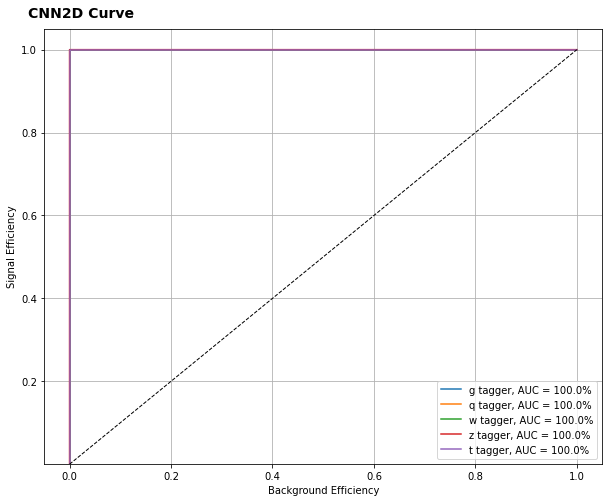

In [13]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'CNN2D Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='CNN2D')

Text(0.25, 0.9, 'Conv_1d_notebook_version')

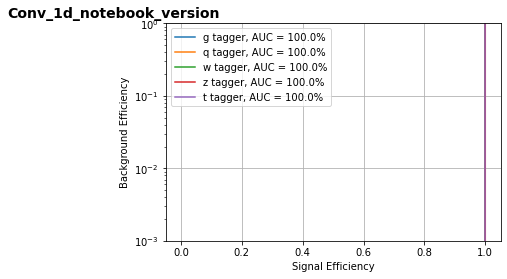

In [11]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'Conv_1d_notebook_version',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)


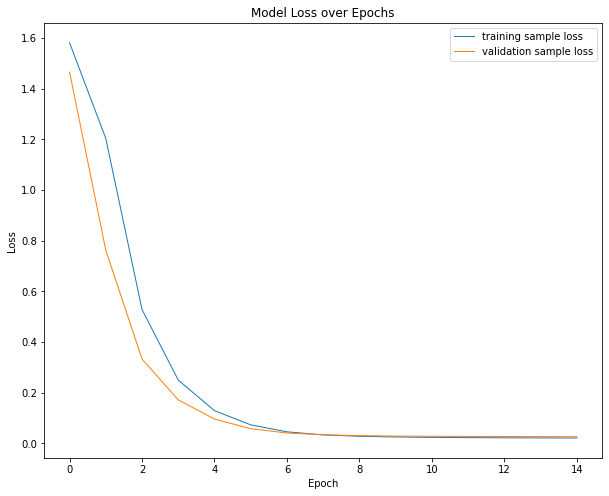

In [12]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

learningCurve(history)